### Review

Quick recap of what we've done so far:
- Source the data from ismyshowcancelled.com, TVMAZE, and OMDB
- Deduped, cleaned, and re-pulled where necessary
- Explored the data and created custom features
- Clustered the data to better understand it
- Created numerous supervised models based on feature and parameter optimized logistic regressions, random forests, gradient boosted classifiers, and SVM classifiers
- Tried various NLP models to boost performance: BOW, TFIDF, various applications of word2vec, and a Keras sequential neural net
- Arrived at two models: one for predicting pre-premiere performance, and another for post-premiere (which includes IMDB data)

So now that that's all done, let's further evaluate the model on some new data and have some fun with it!

### Holdout Years
Now that we've run many model variations and have confidence in the best performers, let's bring those in and see what they predict for some shows that we've held out. These shows include those from 2017 and 2018 that haven't had a chance to run for 2 years and are therefore ineligible for the two season cancellation variable.

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn import metrics 

# Reading in X and Y for our best models
X = pd.read_pickle("Extras/best_feat_x")
X_imdb = pd.read_pickle("Extras/best_feat_x_imdb")
Y = pd.read_pickle("Extras/y")

# Reading in the highest performing pre-premiere model - gradient boosted classifier
pre_mod = joblib.load("Extras/GS_GBC.pkl")

# Reading in the highest performing post-premiere/IMDB model - random forest classifier
post_mod = joblib.load("Extras/GS_imdb_rfc.pkl")

As a refresher, here's how the pre-premiere models compared:

In [2]:
model_comp = pd.read_pickle("Extras/model_comp.pkl")
model_comp

,accuracy,precision,recall
Regularized Logistic Regression,0.672492,0.615592,0.608964
Random Forest Classifier,0.726444,0.681582,0.63759
Gradient Boosted Classifier,0.728723,0.689536,0.659029
SVM Classifier,0.723404,0.678964,0.664367


In [3]:
# Cross validating just to confirm that we're getting the same accuracy as before
cross_val_score(pre_mod.best_estimator_,X,Y).mean()

0.72873522569281912

And the "post-premiere" models with IMDB information:

In [4]:
model_comp_imdb = pd.read_pickle("Extras/model_comp_imdb.pkl")
model_comp_imdb

,accuracy,precision,recall
Regularized Logistic Regression,0.875380,0.889887,0.805436
Random Forest Classifier,0.907295,0.880020,0.875012
Gradient Boosted Classifier,0.903495,0.892928,0.878577
SVM Classifier,0.904255,0.893174,0.880398


Now that we have our models, let's see what they predict for some of these recent shows that we didn't train on, with the understanding that we can't determine accuracy for them given that they're not fully eligible for the reasons given above.

In [5]:
holdout = pd.read_pickle("cleaned_dataset_v4.pkl")

# Holdout for pre-premiere can include 2018 since all necessary information is available now
holdout = holdout[(holdout['start_year'].isin([2018,2017])) & (holdout['imdb_rating'].notnull()) & (holdout['log_imdb_votes_per_season'].notnull())]
holdout_imdb = holdout.copy()

# Creating X's and Y
X_hold = pd.concat([pd.get_dummies(holdout[['network_type','country','tvmaze_ep_day','primary_genre']].apply(lambda x: x.astype('O')))\
               ,holdout[['risky_2season','start_year','quarter','month']]],axis=1)

X_imdb_hold = pd.concat([pd.get_dummies(holdout_imdb[['network_type']].apply(lambda x: x.astype('O')))\
               ,holdout_imdb[['risky_2season','log_imdb_votes_per_season','imdb_rating','start_year']]],axis=1)

Y_hold = holdout['two_season_cancel']
Y_hold_imdb = holdout_imdb['two_season_cancel']

hold_df = pd.concat([X_hold,Y_hold],axis=1)
hold_df_imdb = pd.concat([X_imdb_hold,Y_hold_imdb],axis=1)

In [6]:
# For taking a look at just ones that we know got cancelled
hold_df_canc = hold_df[hold_df['two_season_cancel'] == 1]
hold_df_imdb_canc = hold_df_imdb[hold_df_imdb['two_season_cancel'] == 1]

# X's for cancelled shows
X_hold_canc = hold_df_canc.iloc[:,:-1]
X_hold_imdb_canc = hold_df_imdb_canc.iloc[:,:-1]

# Y's for cancelled shows (all values = 1)
Y_hold_canc = hold_df_canc['two_season_cancel']
Y_hold_imdb_canc = hold_df_imdb_canc['two_season_cancel']

In [7]:
Y_pred = pre_mod.predict(X_hold_canc)

early_recall = metrics.accuracy_score(Y_pred,Y_hold_canc)
print('Our pre-premiere model correctly predicts {0:.0%} of the shows that have already been cancelled.'\
      .format(early_recall))

Our pre-premiere model correctly predicts 65% of the shows that have already been cancelled.


In [9]:
Y_pred_imdb = post_mod.predict(X_hold_imdb_canc)

early_recall = metrics.accuracy_score(Y_pred_imdb,Y_hold_imdb_canc)
print('Our post-premiere model correctly predicts {0:.0%} of the shows that have already been cancelled.'\
      .format(early_recall))

Our post-premiere model correctly predicts 78% of the shows that have already been cancelled.


So, how should we interpret this metric? We can think of it as an early cut of the recall score, which is the number of true positives / (true positives + false negatives), or in other words the number of cancelled shows that we correctly identify.

Recalling our earlier model, we were able to generate recall scores of 68% and 87%, respectively. So this isn't half bad! But clearly our models are a tad less accurate when applied to this fresh set of data. Why? A few reasons:

- For one, the recall for these 2017 & 2018 shows will change. Some shows that are not yet cancelled will be before their two year mark. If our model is good at finding those types of shows (which I think it should be!), our recall could increase.
- 2017 & 2018 could be different beasts than the years featured in our training data. The TV industry continues to change rapidly, as ratings decline for broadcast and cable programming across the board while the volume of original programming has exploded. It's worth noting that much of the new content is coming from streaming platforms, which operate on different economic models than traditional TV and are known to have more patience with shows than ad-driven networks.
- Our variable of log IMDB votes per season is powerful; in fact, it drives the post-premiere model along with the audience review rating. That said, it's imperfect in its application to future shows. Longer running shows, for example, may not collect votes at the same rate as they did prior, increasing the divisor in this equation, which would deflate these shows' value for this metric relative to shorter running shows that might not end up being as successful (something we noticed in the data exploration notebook). Additionally, IMDB continues to become more popular as a platform and thus shows get more votes in more recent years by default. A revised metric that normalizes figures vs. expectation given the length of their run and the year of launch could provide a feature that might perform better for future years but would perform worse based on our available training set.

### Experimenting with shows
Now that we've taken a closer look at how our model performs against some new data, let's have some fun with it! Let's throw out a few predictions for some shows we may have heard about.

In [10]:
all_shows = pd.read_pickle("cleaned_dataset_v4.pkl")
all_shows = pd.concat([pd.get_dummies(all_shows[['network_type','country','tvmaze_ep_day','primary_genre']].apply(lambda x: x.astype('O')))\
               ,all_shows[['risky_2season','start_year','quarter','month','title','status','two_season_cancel','network']]],axis=1)
coming_soon = all_shows.copy()
coming_soon = coming_soon.loc[all_shows['status'] == 'Coming Soon']

X_cs = coming_soon.drop(['title','status','two_season_cancel','network'],axis=1)
Y_cs = coming_soon['two_season_cancel']

coming_soon['pred'] = pre_mod.predict(X_cs)

In [11]:
coming_soon.head(10).loc[:,['title','status','pred']]

,title,status,pred
1,100 Code,Coming Soon,1
224,Burden of Truth,Coming Soon,1
287,Condor,Coming Soon,0
357,Dietland,Coming Soon,0
511,Gordon Ramsay's 24 Hours to Hell and Back,Coming Soon,1
556,Heathers,Coming Soon,0
749,Love Is _,Coming Soon,0
946,Pose,Coming Soon,0
999,Reverie,Coming Soon,1
1078,Sharp Objects,Coming Soon,0


For example, it looks like our model thinks Reverie on NBC will get cancelled. That show has premiered since I collected the data, and it's got some [bad reviews](http://www.metacritic.com/tv/reverie) and [poor ratings](https://variety.com/2018/tv/news/tv-ratings-american-ninja-warrior-reverie-premiere-nbc-1202826547/). Pose, a show on FX that has also just premiered, has [pretty bad ratings](http://tvbythenumbers.zap2it.com/daily-ratings/sunday-cable-ratings-june-3-2018/) as well. Our model however predicts that series will last past season two. Are we right? only time will tell!

In [12]:
X_all = all_shows.drop(['title','status','two_season_cancel','network'],axis=1)
Y_all = all_shows['two_season_cancel']

all_shows['pred'] = pre_mod.predict(X_all)

In [13]:
experimental = all_shows.copy()

In [16]:
experimental = experimental[(experimental['pred'] ==1)&(experimental['network']=='CBC')]
experimental.iloc[0]

network_type_basic_cable                1
network_type_broadcast                  0
network_type_premium_cable              0
network_type_streaming                  0
country_Canada                          1
country_Multiple                        0
country_Other International             0
country_UK                              0
country_USA                             0
tvmaze_ep_day_Friday                    0
tvmaze_ep_day_Monday                    1
tvmaze_ep_day_Multiple                  0
tvmaze_ep_day_Saturday                  0
tvmaze_ep_day_Sunday                    0
tvmaze_ep_day_Thursday                  0
tvmaze_ep_day_Tuesday                   0
tvmaze_ep_day_Wednesday                 0
primary_genre_Comedy                    1
primary_genre_Drama                     0
primary_genre_Game Show                 0
primary_genre_Reality                   0
primary_genre_Sci-fi                    0
primary_genre_Talk                      0
risky_2season                     

In [17]:
# Changing the air date to Monday
experimental.loc[:,'tvmaze_ep_day_Monday'] = 0
experimental.loc[:,'tvmaze_ep_day_Sunday'] = 1

# Premiere month to June and start year to 2000
experimental.loc[:,'month'] = 6
experimental.loc[:,'start_year'] = 2000

In [18]:
experimental.iloc[0]

network_type_basic_cable                1
network_type_broadcast                  0
network_type_premium_cable              0
network_type_streaming                  0
country_Canada                          1
country_Multiple                        0
country_Other International             0
country_UK                              0
country_USA                             0
tvmaze_ep_day_Friday                    0
tvmaze_ep_day_Monday                    0
tvmaze_ep_day_Multiple                  0
tvmaze_ep_day_Saturday                  0
tvmaze_ep_day_Sunday                    1
tvmaze_ep_day_Thursday                  0
tvmaze_ep_day_Tuesday                   0
tvmaze_ep_day_Wednesday                 0
primary_genre_Comedy                    1
primary_genre_Drama                     0
primary_genre_Game Show                 0
primary_genre_Reality                   0
primary_genre_Sci-fi                    0
primary_genre_Talk                      0
risky_2season                     

In [19]:
x_experiment = experimental.drop(['title','status','two_season_cancel','network','pred'],axis=1)
print('Cancellation prediction: {}'.format(pre_mod.predict(x_experiment)[0]))

Cancellation prediction: 0


Interesting - so we know that this show was cancelled and our model predicted as much. But maybe if this show premiered 10 years earlier and premiered on a Sunday in June (a day and month which shows have a lower cancellation rate per our data exploration), then perhaps the show would've found more success. Of course, this is quite a simplistic view and these are not actions that are possible in hindsight, but you can imagine situations where a user of the model does have control over some or all of these levers and can use it to make better decisions. Let's look at another example.

In [141]:
all_shows_imdb = pd.read_pickle("no_na_pre2017_v4.pkl")
all_shows_imdb = pd.concat([pd.get_dummies(all_shows_imdb[['network_type']].apply(lambda x: x.astype('O')))\
               ,all_shows_imdb[['risky_2season','log_imdb_votes_per_season','imdb_rating','start_year','title','two_season_cancel','network']]],axis=1)
all_shows_imdb.index = range(0,len(all_shows_imdb))
all_shows_imdb['pred'] = post_mod.predict(all_shows_imdb.drop(['title','two_season_cancel','network'],axis=1))

In [142]:
experimental = all_shows_imdb.copy()

In [143]:
experimental = experimental[(experimental['two_season_cancel'] ==1)&(experimental['network']=='The CW')\
                            &(experimental['pred'] == 1)]
experimental = experimental.iloc[5]
experimental

network_type_basic_cable                      0
network_type_broadcast                        1
network_type_premium_cable                    0
network_type_streaming                        0
risky_2season                                 1
log_imdb_votes_per_season               8.68237
imdb_rating                                 7.6
start_year                                 2012
title                         Emily Owens, M.D.
two_season_cancel                             1
network                                  The CW
pred                                          1
Name: 332, dtype: object

Let's look at this show: Emily Owens, M.D. Sadly, it was cancelled, but what if it had a better audience rating?

In [144]:
ratings = []
preds = []

for rating in np.arange(0,10,0.1):
    experimental['imdb_rating'] = rating
    x_experiment = pd.DataFrame(experimental).T.drop(['title','two_season_cancel','network','pred'],axis=1)
    pred = post_mod.predict(x_experiment)
    preds.append(pred)
    ratings.append(rating)

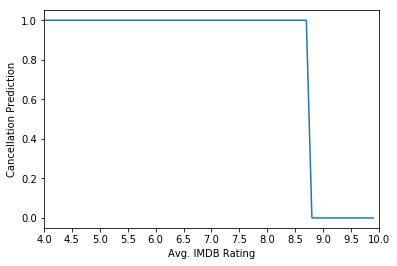

In [149]:
import matplotlib.pyplot as plt
plt.plot(ratings,preds)
plt.xlim(4,10)
plt.xticks(np.arange(4, 10.5, 0.5))
plt.xlabel('Avg. IMDB Rating')
plt.ylabel('Cancellation Prediction')
plt.savefig("Extras/emilyowens_rating_pred.png")
plt.show()

Interesting! Our model says that, all other things being equal, this show might not have been cancelled if it had a rating of 8.6 or above. In other words, perhaps it could have been a "cult classic" of sorts that fans really adored. Of course, making "good" shows that people like is easier said than done!

## Wrapping up
#### How did we do?
Though neither of our models is perfect, I think we did make a dent in helping to understand some of the drivers behind the perennial conundrum of how to pick "winners" in the TV industry and concocted some pretty good models in the meantime. Our product could help writers, producers, and networks get a better sense of what shows are worth investing in and thus make better decisions, even if the model can't tell them conclusively whether a show will succeed or not. Each of these potential users has different levers to pull based on the model's results, such as a creator deciding which networks to pitch to or a network deciding which season and day during which to premiere a show. In the case of the IMDB model, showrunners could consider a change in the direction of a series based on the fan reaction so far. Additionally, would-be fans of a show can determine which shows to invest their time in, helping them to avoid dedicatig themselves to a show that may be cancelled prematurely without a satisfying conclusion!

#### Challenges & Shortcomings
As we mentioned, our model isn't perfect! Here are some challenges that came up:
- This project could be seen as example of the curse of dimensionality and of bias/variance tradeoff. We collected many, many features for each show, and this is only a fraction of all of the metadata that could theoretically be attached to each. Even though we included nearly all of the shows that have premiered in the last 10-15 years, that only amounts to about ~1400 after cleaning. This is pretty small in the scheme of data analytics problems, and as such the more accurate our training models became on small nuances in the data, the more overfit and less applicable to other datasets they became. Our model still worked pretty well and gave substantial improvement vs. a baseline model, but we had to rely on a more rudimentary feature set to do so.
- The application of NLP to taglines, plots, and synopses did not work as effectively as we'd hoped. Here are a few reasons why:
    - There's a disconnect between rote descriptions of a show and its "concept" as we commonly understand to be the basis for TV shows. Our various methods of NLP didn't seem to be able to extract these nuances.
    - Moreoever, no description of a show can capture the execution. Two shows with essentially the same descriptions could be made with different writers, actors, and at different budgets from different studios/networks. In short, these text documents can't adequately capture "quality."
    - The nuances we did pick up were probably more akin to descriptions of topic/genre, and thus were already captured more succinctly in some of our other features, which explains why their 3-4% improvement in accuracy was not additive to our other supervised models. 
    - Had we generated NLP solutions that were able to pick up nuances in show concepts in a highly meaningful way, we'd still be at risk of the bias/variance tradeoff. If our model were to determine via NLP featurization that a show about lawyers in Boston in the late '90s was linked to success based on a show or two, this may still not be a universal, reproducible conclusion!
- Our model is not so great at picking up the nuance which shows succeed within a given network or a given year, since these features are so effective in predicting cancellation rates. If we were to loosen the grip of these features on the predicted outcome, accuracy with our dataset would struggle, but the applicability of the model in certain situations might increase.
- Log IMDB votes per season is a very powerful feature in our model, but has a couple of issues when it comes to go-forward predictions given the rise in the popularity of the site and the seemingly disproportionate amount of votes acquired in the first season vs. latter years. A modified metric might do better in predicting more recent shows, but would have suffered when evaluating our currently available dataset. It would be great if we had votes as of certain time periods after premiere!

#### Productionalization
I would imagine the UI of our product would take the form of an interactive application in which the user could toggle various levers and return predictions of whether or not the show would be cancelled. This could be given with probabilities or other measures of confidence to add nuance to the prediction. The user could then iteratively manipulate series characteristics in order to, say, determine which day the show would best perform on, or the average rating on IMDB one needs to achieve to predict a long run. Once the model is productionalized, there would be some maintenance required on the back-end:
- Continual scraping of ismyshowcancelled.com (or another source that feeds this information more readily), along with metadata supplementation from the likes of TVMaze and OMDB.
- Periodic retraining of the data based on new information, as the model picks up on how certain genres are doing, whether certain years are over/underperforming vs. the previous, etc. The more up to date the data inputs and the model are, the better it will work.
- Since a lot of the models perform similarly well, it could be worth it to revisit the methodology on occasion to see if new model types/parameters are optimal given recent information.

#### Where else could you take this dataset?
This is a fun but challenging dataset, which I'm considering putting on Kaggle or sharing with people who may be interested. With it, you could try to:
- Expand the NLP analysis of the shows, even if not against the target of cancellation. I think deep learning with recurrent neural nets in Keras, for example, might be able to squeeze some interesting learning out of the text documents toward another label like genre. Our rudimentary sequential net indicates that there's definitely potential here. 
- Marry this with advanced content metadata. There are vendors now providing video analysis of scenes and other audiovisual information about shows, which could be trained against cancellation or other targets of interest.
- This would be a pretty solid dataset for creating an item-item recommender system. 
- This is also a pretty interesting dataset for analysis of the TV show ecosystem, and has already helped further my understanding of differences in programming between different networks, over time, and across various other dimensions.

Thanks for reading!!!